# Implementing Dubins Curves
This notebook is intended for testing different libraries or formulations for Dubins curve type path sets to be used for simulation and field planning work in an adaptive sampling/informative path planning regime.

Please note, that you may need to install the following in order to play with the pre-made dubins library:

```pip install dubins```

In [4]:
# Necessary Imports
import dubins
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

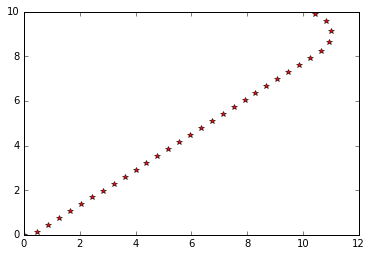

In [27]:
#starting location (x,y,yaw)
q0 = (0, 0, 0)

#goal location (x,y,yaw)
q1 = (10, 10, 3.14)

#radius of feasible turn
turning_radius = 1.0

#sampling "rate" or distance
step_size = 0.5

#find the shortest path, returns a dubins object
path = dubins.shortest_path(q0, q1, turning_radius)

#sample the path and return the points along the path
configurations, _ = path.sample_many(step_size)

#plot the path
x = []
y = []
for sample_points in configurations:
    x.append(sample_points[0])
    y.append(sample_points[1])
plt.plot(x,y,'r*')

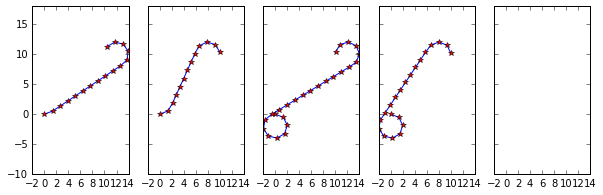

In [61]:
'''
LSL = 0
LSR = 1
RSL = 2
RSR = 3
RLR = 4
LRL = 5
'''
words = [0,1,2,3,4,5]

#starting location (x,y,yaw)
q0 = (0, 0, 0)

#goal location (x,y,yaw)
q1 = (10, 10, -1.57)

#radius of feasible turn
turning_radius = 2.0

#sampling "rate" or distance
step_size = 1.5

fig,ax = plt.subplots(1,5,sharex=True,sharey=True)
fig.set_size_inches(10,3)

for a,word in zip(ax,words):
    path = dubins.path(q0, q1, turning_radius, word)
    if path != None:
        configurations, _ = path.sample_many(step_size)
        configurations = np.array(configurations)
        a.axis('equal')
        a.plot(configurations[:,0], configurations[:,1], 'b-')
        a.plot(configurations[:,0], configurations[:,1], 'r*')
        
plt.show()


# Making our Own Path Set Class

The interface for the Dubins curve library is nice, but not necessarily what we want for our vehicles at the moment. Now we will create a flexible path set library.

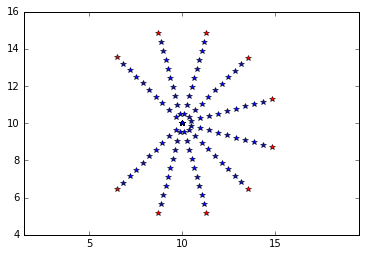

In [112]:
class Path_Generator:
    '''The Path_Generator class, initially parameterized with:
    
    frontier_size (int) the number of points on the frontier we should consider for navigation
    horizon_length (float) distance between the vehicle and the horizon to consider
    turning_radius (float) the feasible turning radius for the vehicle
    sample_step (float) the unit length along the path from which to draw a sample'''
    
    def __init__(self, frontier_size, horizon_length, turning_radius, sample_step):
        self.fs = frontier_size
        self.hl = horizon_length
        self.tr = turning_radius
        self.ss = sample_step
        
        self.goals = []
        self.cp = (0,0,0)
        
    def generate_frontier_points(self, current_pose):
        '''From the frontier_size and horizon_length, generate the frontier points to goal'''
        angle = np.linspace(-2.35,2.35,self.fs)
        self.goals = [(self.hl*np.cos(current_pose[2]+a)+current_pose[0], self.hl*np.sin(current_pose[2]+a)+current_pose[1], current_pose[2]+a) for a in angle]
        return self.goals
        
    def make_sample_paths(self, current_pose):
        '''Connect the current_pose to the goal places'''
        cp = np.array(current_pose)
        coords = {}
        for i,goal in enumerate(self.goals):
            g = np.array(goal)
            distance = np.sqrt((cp[0]-g[0])**2 + (cp[1]-g[1])**2)
            samples = int(round(distance/self.ss))
            
            for i in range(0,samples):
                x = cp[0]+(i*self.ss)*np.cos(g[2])
                y = cp[1]+(i*self.ss)*np.sin(g[2])
                try: 
                    coords[i].append((x,y))
                except:
                    coords[i] = []
                    coords[i].append((x,y))
        return coords

PG = Path_Generator(10, 5, 5, 0.5)
m = PG.generate_frontier_points((10,10,0))
m = np.array(m)

l = PG.make_sample_paths((10,10,0))

fig,ax = plt.subplots(1,1)
ax.axis('equal')
for key,val in l.items():
    f = np.array(val)
    plt.plot(f[:,0], f[:,1], 'b*')
    
plt.plot(m[:,0], m[:,1], 'r*')
# plt.plot(l[:,0], l[:,1], 'b*')
plt.show()
        
    

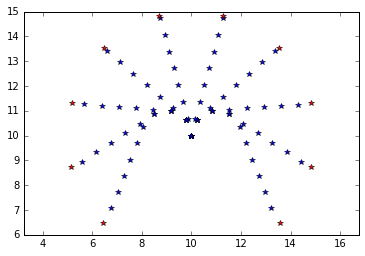

In [115]:
class Dubins_Path_Generator:
    '''The Path_Generator class, initially parameterized with:
    
    frontier_size (int) the number of points on the frontier we should consider for navigation
    horizon_length (float) distance between the vehicle and the horizon to consider
    turning_radius (float) the feasible turning radius for the vehicle
    sample_step (float) the unit length along the path from which to draw a sample'''
    
    def __init__(self, frontier_size, horizon_length, turning_radius, sample_step):
        self.fs = frontier_size
        self.hl = horizon_length
        self.tr = turning_radius
        self.ss = sample_step
        
        self.goals = []
        self.cp = (0,0,0)
        
    def generate_frontier_points(self, current_pose):
        '''From the frontier_size and horizon_length, generate the frontier points to goal'''
        angle = np.linspace(-2.35,2.35,self.fs)
        self.goals = [(self.hl*np.cos(a+current_pose[2])+current_pose[0], self.hl*np.sin(a+current_pose[2])+current_pose[1], a+current_pose[2]) for a in angle]
        return self.goals
        
    def make_sample_paths(self, current_pose):
        '''Connect the current_pose to the goal places'''
        coords = {}
        for i,goal in enumerate(self.goals):
            g = (goal[0],goal[1],current_pose[2])
            path = dubins.shortest_path(current_pose, goal, self.tr)
            configurations, _ = path.sample_many(self.ss)
            coords[i] = configurations
        return coords

PG = Dubins_Path_Generator(10, 5, 1, 0.7)
m = PG.generate_frontier_points((10,10,1.57))
m = np.array(m)

l = PG.make_sample_paths((10,10,1.57))

fig,ax = plt.subplots(1,1)
ax.axis('equal')
for key,val in l.items():
    f = np.array(val)
    plt.plot(f[:,0], f[:,1], 'b*')
    
plt.plot(m[:,0], m[:,1], 'r*')
# plt.plot(l[:,0], l[:,1], 'b*')
plt.show()
        
    